# Fit the spectrum of CTIO Data in January 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/IN2P3/CNRS France
- date   : January 19th 2017
- update : January 25 2017

The goal is to calibrate in wavelength the X axis.
For this the raw spectra in the dat are read as well as the spectra simulated.
The simulated may have been checked by View_SimSpectrum_XX.ipynb

In [229]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [230]:
print theNotebook

Fit_Spectrum_HD60753


In [231]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [232]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [233]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [234]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [235]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [236]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [237]:
from IPython.display import Image, display

In [238]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [239]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [240]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## Choose the Fit order

In [241]:
FIT_ORDER=2

## Output directory for images generated in the notebook view (not true fits images)

In [242]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [243]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

- Left and Right spectra in the data

In [244]:
inputdir="./spectrum_fitsspec"
object_name='HD60753'

### Output fits file

In [245]:
outputdir="./spectrum_calibspec"

In [246]:
ensure_dir(outputdir)

In [247]:
#simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10'
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_432_441'

### Input of fits

In [248]:
simspectrasummary='AllSimSpectra_'+object_name+'.fits'

### Results of fits

In [249]:
simspectracalibresult='SpecCalibFitResults_'+object_name +'.fits'

## Location of corrected images
----------------------------------

In [250]:
input_filelist=os.listdir(inputdir) 

In [251]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [252]:
print input_filelist[0:5]

['finalSpectra_HD60753_20170118_432.fits'
 'finalSpectra_HD60753_20170118_433.fits'
 'finalSpectra_HD60753_20170118_434.fits'
 'finalSpectra_HD60753_20170118_435.fits'
 'finalSpectra_HD60753_20170118_436.fits']


In [253]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [254]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0


    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^finalSpectra_HD60753_20170118_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages    
    

In [255]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [256]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [257]:
print indexes_files

[432 433 434 435 436 437 438 439 440 441]


In [258]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [259]:
sorted_numbers=indexes_files[sorted_indexes]

In [260]:
print sorted_indexes

[0 1 2 3 4 5 6 7 8 9]


In [261]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [262]:
#sorted_files

## Build full filename
----------------------------

In [263]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [264]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [265]:
print sorted_filenames.shape

(10,)


## Acces to spectrum data
----------------------------------

In [266]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [267]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra = []
    all_rightspectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        left_spectrum=table_data.field('RawLeftSpec')
        right_spectrum=table_data.field('RawRightSpec')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_leftspectra.append(left_spectrum)
        all_rightspectra.append(right_spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra

In [268]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra,all_rightspectra=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [269]:
len(all_rightspectra)

10

In [270]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os


def ShowSpectra(all_spectra,all_titles,object_name,dir_top_images,figname):
    """
    ShowSpectra: 
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/4)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,10))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%4
        iy=index/4
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,3000.)
        #axarr[iy,ix].set_xlim(0.,500.)
        axarr[iy,ix].grid(True)
      
    title='splited spectra'
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)

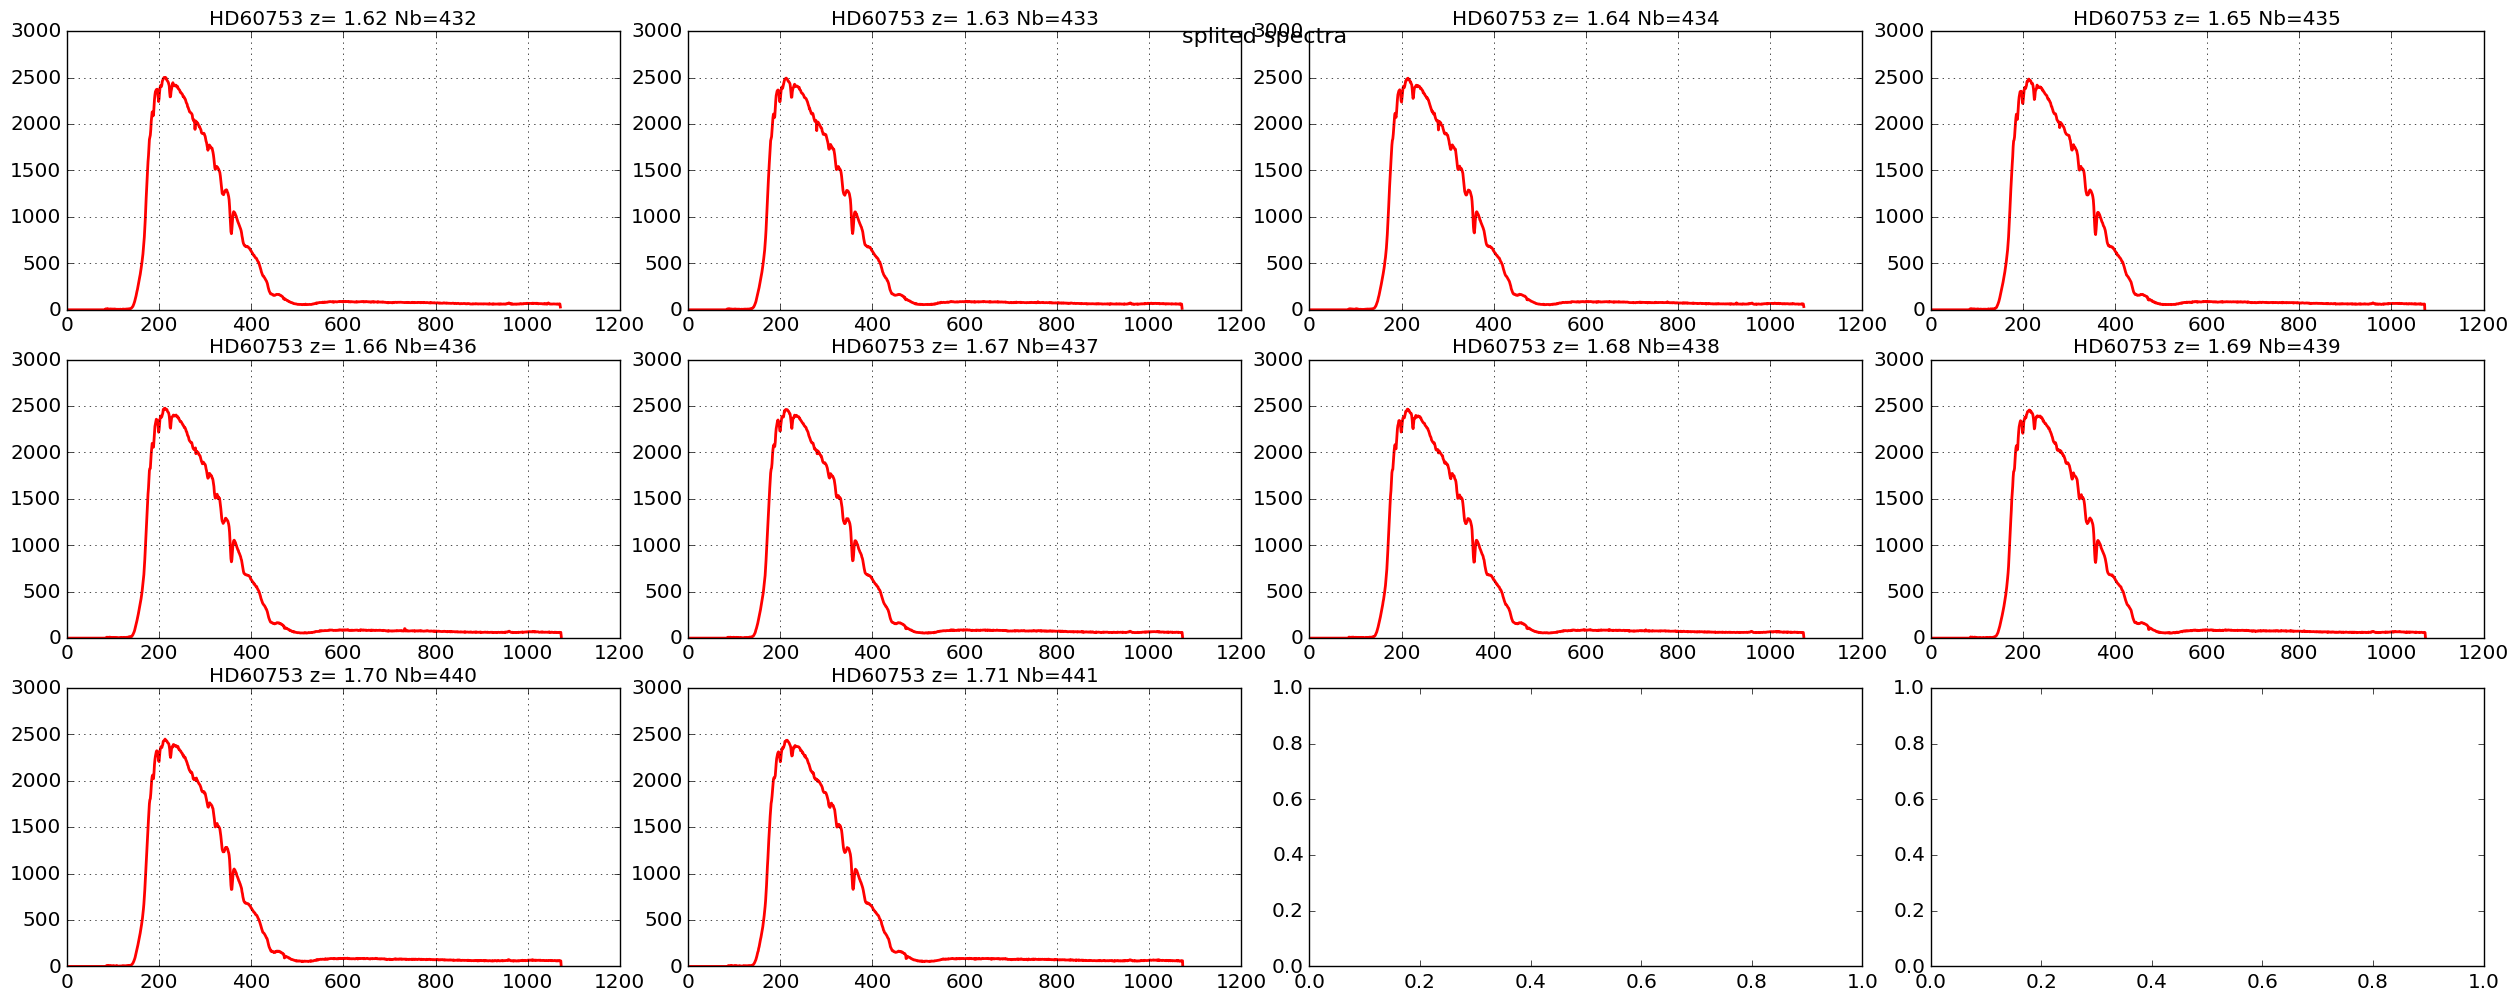

In [271]:
ShowSpectra(all_rightspectra,all_titles,object_name,dir_top_images,'rightspectra.pdf')

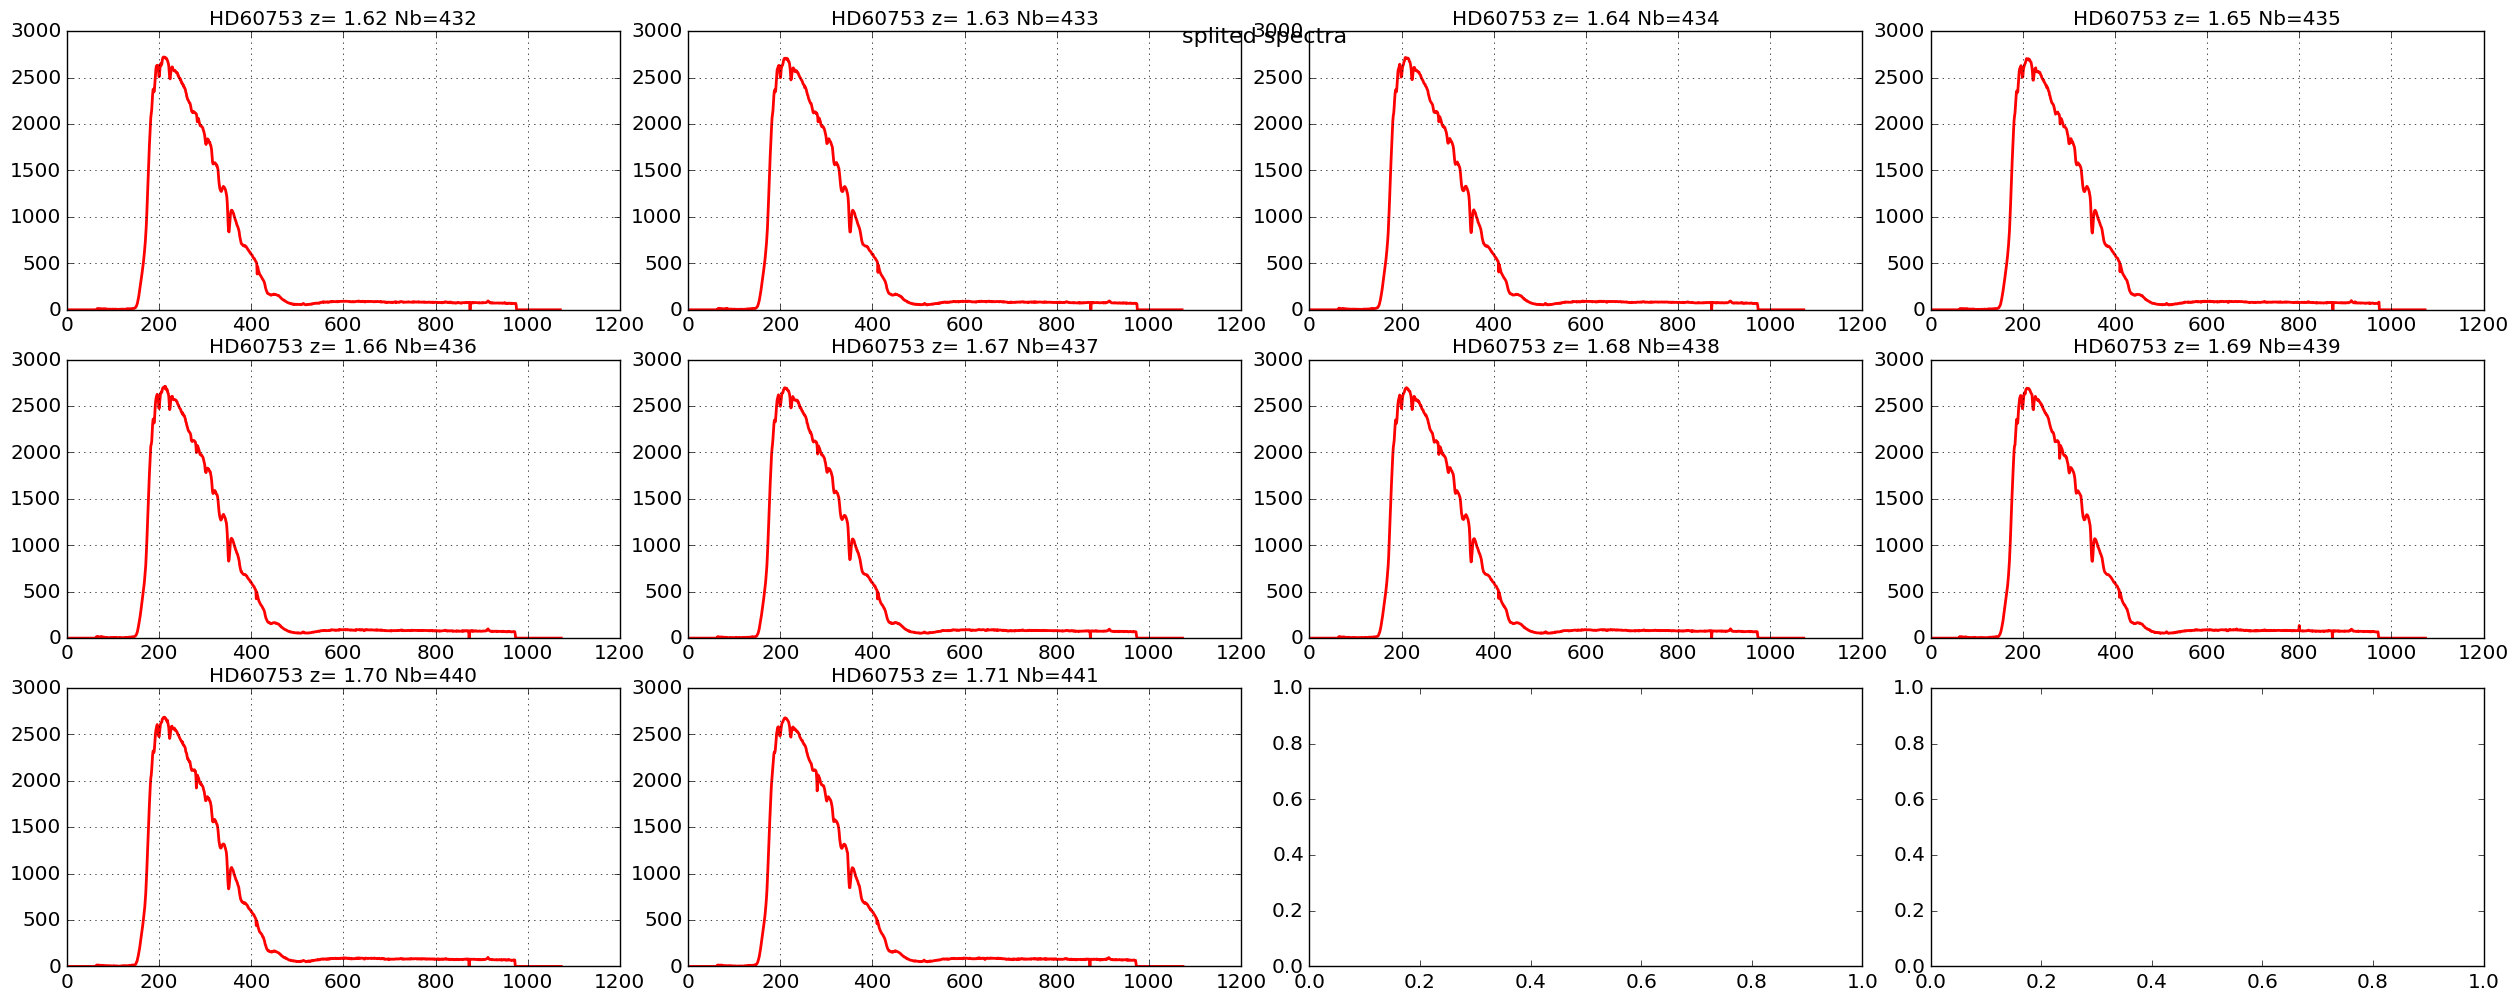

In [272]:
ShowSpectra(all_leftspectra,all_titles,object_name,dir_top_images,'leftspectra.pdf')

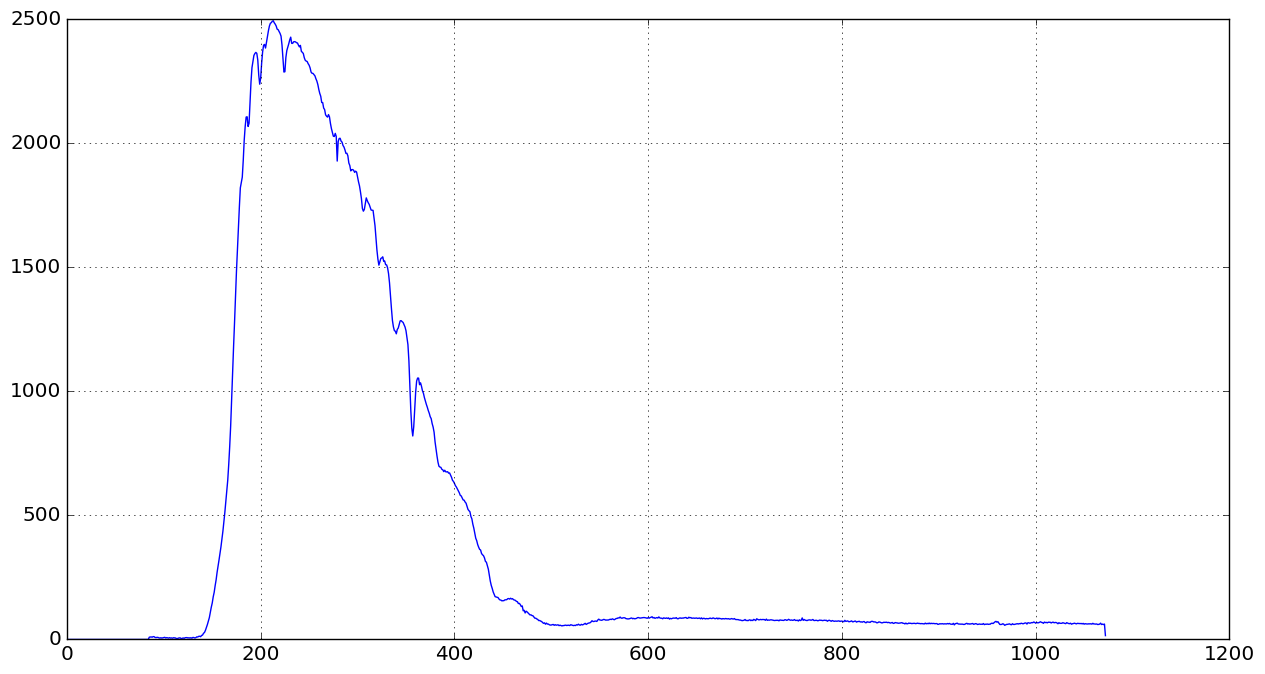

In [273]:
plt.figure(figsize=(15,8))
plt.plot(all_rightspectra[1])
#plt.xlim(0,500)
plt.grid(True)

## Read the simulated spectra

In [274]:
inputsim_filelist=os.listdir(simspecdir) 

In [275]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [276]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD60753_Nev432_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev433_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev434_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev435_y2016_m01_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD60753_Nev436_y2016_m01_aver_spectra.fits']


In [277]:
print re.findall('^RT_CT_pp_us_sa_rt_HD60753_Nev(.*)_y2016_m01_aver_spectra.fits',inputsim_filelist[0])

['432']


In [278]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [279]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD60753_Nev(.*)_y2016_m01_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [280]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [281]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [282]:
print indexes_simfiles

[432 433 434 435 436 437 438 439 440 441]


In [283]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [284]:
sorted_simindexes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [285]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [286]:
print sorted_simnumbers # check

[432 433 434 435 436 437 438 439 440 441]


In [287]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [288]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_432_441/RT_CT_pp_us_sa_rt_HD60753_Nev432_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_432_441/RT_CT_pp_us_sa_rt_HD60753_Nev433_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_432_441/RT_CT_pp_us_sa_rt_HD60753_Nev434_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_432_441/RT_CT_pp_us_sa_rt_HD60753_Nev435_y2016_m01_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2017/simu_spectra/fits/HD60753/2017_01_18/R400_432_441/RT_CT_pp_us_sa_rt_HD60753_Nev436_y2016_m01_aver_spectra.fits']


In [289]:
hdu_list=fits.open(sorted_simfiles[0])
header=hdu_list[0].header

In [290]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD60753 '                                                            AIRMASS =     1.61899995803833                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2017-01-19T08:43:01.671'                                             EXPOSURE=                 60.0                                                  FILENAME= 'trim_20170118_432.fits'                                              COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [291]:
 table_data=hdu_list[1].data

In [292]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [293]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

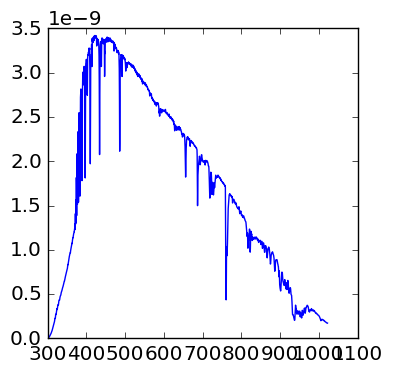

In [294]:
plt.plot(simwavelength,simspectra )

In [295]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        print idx
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [296]:
# crash because it blows up fits IO capability : too many files open
#all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

In [297]:
# better open a singel file produced by view_SimSpectrum

hdu_list=fits.open(simspectrasummary)
header=hdu_list[0].header
print header

simspectra_data=hdu_list[0].data

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1894                                                  NAXIS2  =                   11                                                  EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

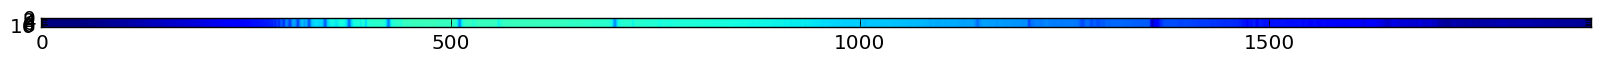

In [298]:
plt.figure(figsize=(20,20))
plt.imshow(simspectra_data[:,:],vmin=0,vmax=8e-9)

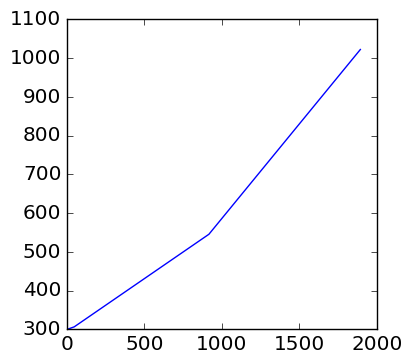

In [299]:
plt.plot(simspectra_data[0,:])

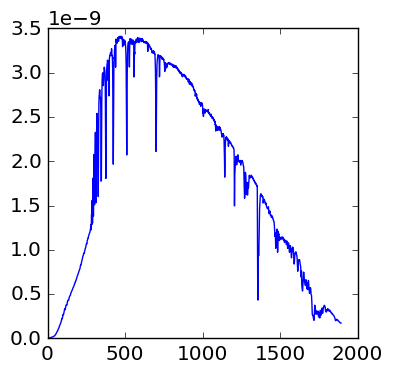

In [300]:
plt.plot(simspectra_data[2,:])

In [301]:
wl_O2Aline=759.37
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175

#wl_Naline=589.592+1
#wl_Heline=587.5618-1


#wl_Hgline=546.073
#wl_Feline=527.039
wl_calib= np.array([wl_O2Aline, wl_Haline, wl_Hbline, wl_Hgline,wl_Hdline ])

## Comparison of spectra

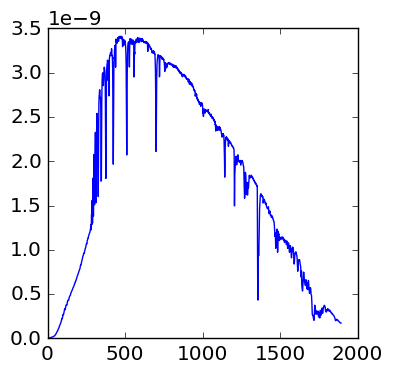

In [302]:
plt.plot(simspectra_data[2,:])

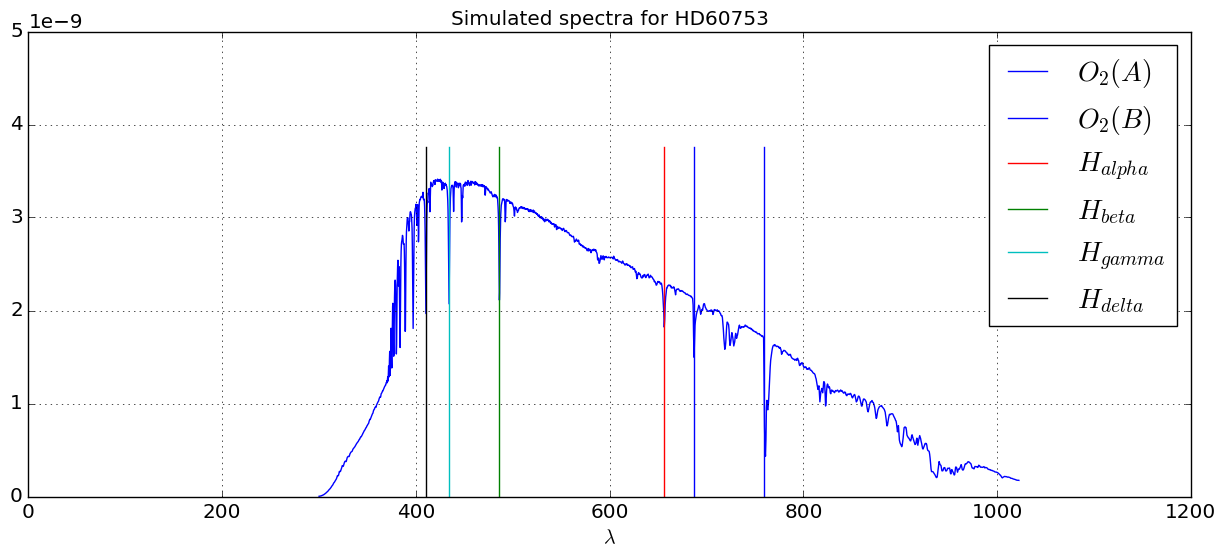

In [303]:
ymax=simspectra_data[2,:].max()*1.1
ymin=simspectra_data[2,:].min()
plt.figure(figsize=(15,6))
plt.plot(simspectra_data[0,:],simspectra_data[2,:])

plt.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
plt.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
plt.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
plt.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
plt.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
plt.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)

plt.legend(loc='best',fontsize=20)
plt.ylim(0.,0.5e-8)
plt.xlim(0,1200)
plt.xlabel("$\lambda$")
title = 'Simulated spectra for {}'.format(object_name)
plt.title(title)
plt.grid(True)
figfilename=os.path.join(dir_top_images,'simspectra_sample.pdf')
plt.savefig(figfilename)

# define the range where to search the minimum

In [304]:
pixminO2=720/2-10
pixmaxO2=750/2-10

pixminHa=610/2-5
pixmaxHa=630/2-5

pixminHb=440/2
pixmaxHb=460/2

pixminHg=395/2
pixmaxHg=410/2

pixminHd=374/2
pixmaxHd=382/2

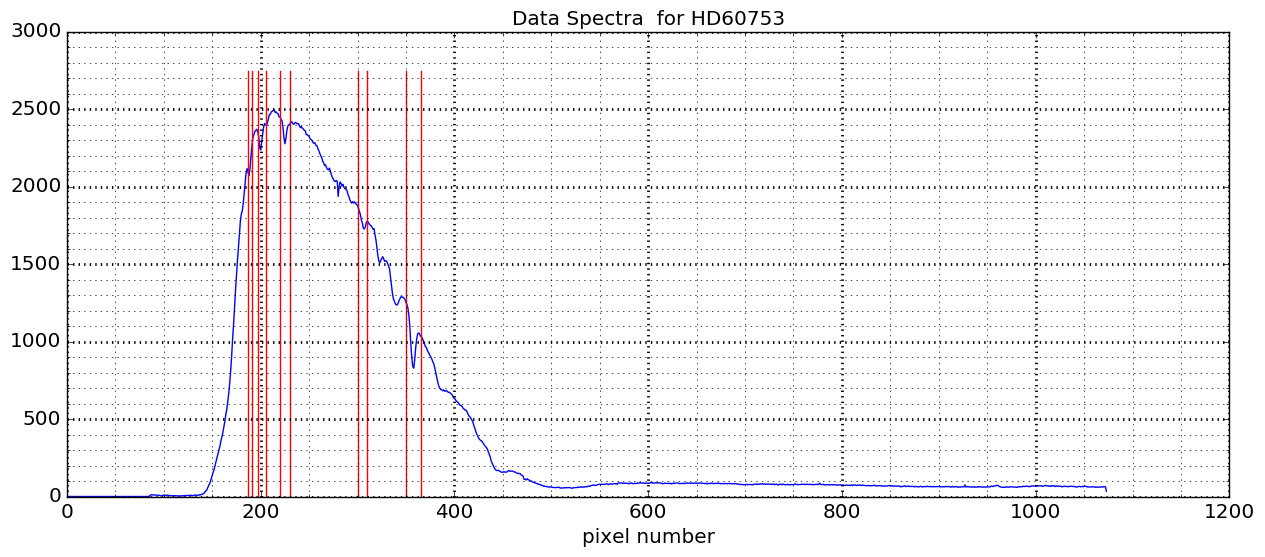

In [305]:
ymax=all_rightspectra[1].max()*1.1
ymin=0

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(all_rightspectra[2])
#ax.set_xlim(0,500)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
# O2 boundary
ax.plot([pixminO2,pixminO2],[ymin,ymax],'r-')
ax.plot([pixmaxO2,pixmaxO2],[ymin,ymax],'r-')

ax.plot([pixminHa,pixminHa],[ymin,ymax],'r-')
ax.plot([pixmaxHa,pixmaxHa],[ymin,ymax],'r-')

ax.plot([pixminHb,pixminHb],[ymin,ymax],'r-')
ax.plot([pixmaxHb,pixmaxHb],[ymin,ymax],'r-')

ax.plot([pixminHg,pixminHg],[ymin,ymax],'r-')
ax.plot([pixmaxHg,pixmaxHg],[ymin,ymax],'r-')

ax.plot([pixminHd,pixminHd],[ymin,ymax],'r-')
ax.plot([pixmaxHd,pixmaxHd],[ymin,ymax],'r-')

title = 'Data Spectra  for {}'.format(object_name)
plt.title(title)
plt.xlabel('pixel number')
figfilename=os.path.join(dir_top_images,'lineselectionregions_right_sample.pdf')
plt.savefig(figfilename)

In [306]:
def FindO2line(spectrum):
    peak_O2=np.min(spectrum[pixminO2:pixmaxO2])
    indexes_O2=np.where(spectrum==peak_O2)
    theO2index=np.where(np.logical_and(np.greater(indexes_O2,pixminO2), np.less(indexes_O2,pixmaxO2)), indexes_O2,0)
    return theO2index, peak_O2

In [307]:
def FindHaline(spectrum):
    peak_Ha=np.min(spectrum[pixminHa:pixmaxHa])
    indexes_Ha=np.where(spectrum==peak_Ha)
    theHaindex=np.where(np.logical_and(np.greater(indexes_Ha,pixminHa), np.less(indexes_Ha,pixmaxHa)), indexes_Ha,0)
    return theHaindex, peak_Ha

In [308]:
def FindHbline(spectrum):
    peak_Hb=np.min(spectrum[pixminHb:pixmaxHb])
    indexes_Hb=np.where(spectrum==peak_Hb)
    theHbindex=np.where(np.logical_and(np.greater(indexes_Hb,pixminHb), np.less(indexes_Hb,pixmaxHb)), indexes_Hb,0)
    return theHbindex, peak_Hb

In [309]:
def FindHgline(spectrum):
    peak_Hg=np.min(spectrum[pixminHg:pixmaxHg])
    indexes_Hg=np.where(spectrum==peak_Hg)
    theHgindex=np.where(np.logical_and(np.greater(indexes_Hg,pixminHg), np.less(indexes_Hg,pixmaxHg)), indexes_Hg,0)
    return theHgindex, peak_Hg

In [310]:
def FindHdline(spectrum):
    peak_Hd=np.min(spectrum[pixminHd:pixmaxHd])
    indexes_Hd=np.where(spectrum==peak_Hd)
    theHdindex=np.where(np.logical_and(np.greater(indexes_Hd,pixminHd), np.less(indexes_Hd,pixmaxHd)), indexes_Hd,0)
    return theHdindex, peak_Hd

In [311]:
theO2index, peak_O2=FindO2line(all_rightspectra[1])
theHaindex, peak_Ha=FindHaline(all_rightspectra[1])
theHbindex, peak_Hb=FindHbline(all_rightspectra[1])
theHgindex, peak_Hg=FindHgline(all_rightspectra[1])
theHdindex, peak_Hd=FindHdline(all_rightspectra[1])

In [312]:
print  theO2index,theHaindex, theHbindex,theHgindex,theHdindex

[[357]] [[306]] [[224]] [[199]] [[0]]


In [313]:
def FindLines(spec):
    indexO2,peak_O2=FindO2line(spec)
    indexHa,peakHa=FindHaline(spec)
    indexHb,peakHb=FindHbline(spec)
    indexHg,peakHg=FindHgline(spec)
    indexHd,peakHd=FindHdline(spec)
    return indexO2[0][0],indexHa[0][0],indexHb[0][0],indexHg[0][0],indexHd[0][0]

In [314]:
lpix=FindLines(all_rightspectra[1])

In [315]:

YY= np.array([wl_O2Aline,wl_Haline,wl_Hbline,wl_Hgline,wl_Hdline])
XX=np.array([np.array(lpix)]).flatten()

In [316]:
YY

array([ 759.37 ,  656.281,  486.134,  434.047,  410.175])

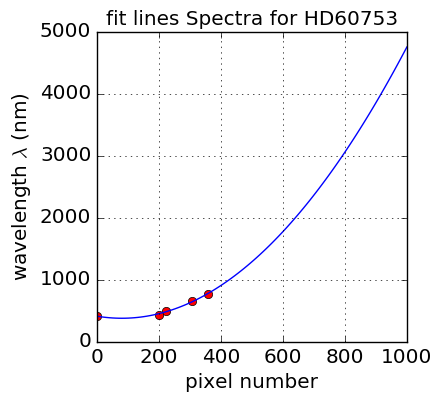

In [317]:
plt.plot(XX,YY,'ro')
z =  np.polyfit(XX,YY, FIT_ORDER)
fitcurve = np.poly1d(z)
x_fit=np.linspace(0,1000,100)
y_fit=fitcurve(x_fit)
plt.plot(x_fit,y_fit,'b-')
#plt.xlim(0,500)
#plt.ylim(0,1100)
plt.grid(True)
title = 'fit lines Spectra for {}'.format(object_name)
plt.title(title)
plt.xlabel('pixel number')
plt.ylabel('wavelength $\lambda$ (nm)')
figfilename=os.path.join(dir_top_images,'lineselectionregions_sample.pdf')
plt.savefig(figfilename)

## Find Absorption lines
==================================

In [318]:
#%%cython
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def FindAllAbsorptionLines(all_spectra,all_titles,object_name,figname):
    """
    FindAbsorptionLines: Show the raw images without background subtraction
    ==============
    """
    NBABSLINES=5
    NBSPECTRA=len(all_spectra)
    MAXIMGROW=int(NBSPECTRA/4)+1
    
    all_absorptionline_pix=np.zeros((NBSPECTRA,NBABSLINES))
    
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,10))
    f.tight_layout()

    for index in np.arange(0,NBSPECTRA):
        ix=index%4
        iy=index/4
        spectrum=all_spectra[index]
        
        ymax=spectrum.max()*1.1
        ymin=0
        
        axarr[iy,ix].plot(spectrum,'b-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(ymin,ymax)
        axarr[iy,ix].set_xlim(0.,600.)
        axarr[iy,ix].grid(True)

        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
        # O2 boundary
        axarr[iy,ix].plot([pixminO2,pixminO2],[ymin,ymax],'r-')
        axarr[iy,ix].plot([pixmaxO2,pixmaxO2],[ymin,ymax],'r-')

        axarr[iy,ix].plot([pixminHa,pixminHa],[ymin,ymax],'r-')
        axarr[iy,ix].plot([pixmaxHa,pixmaxHa],[ymin,ymax],'r-')

        axarr[iy,ix].plot([pixminHb,pixminHb],[ymin,ymax],'r-')
        axarr[iy,ix].plot([pixmaxHb,pixmaxHb],[ymin,ymax],'r-')

        axarr[iy,ix].plot([pixminHg,pixminHg],[ymin,ymax],'r-')
        axarr[iy,ix].plot([pixmaxHg,pixmaxHg],[ymin,ymax],'r-')
        
        axarr[iy,ix].plot([pixminHd,pixminHd],[ymin,ymax],'r-')
        axarr[iy,ix].plot([pixmaxHd,pixmaxHd],[ymin,ymax],'r-')

        absorptionlines_pix=FindLines(spectrum)
        all_absorptionline_pix[index,:]=absorptionlines_pix
        
        figfilename=os.path.join(dir_top_images,figname)
        plt.savefig(figfilename)
    
    return all_absorptionline_pix 

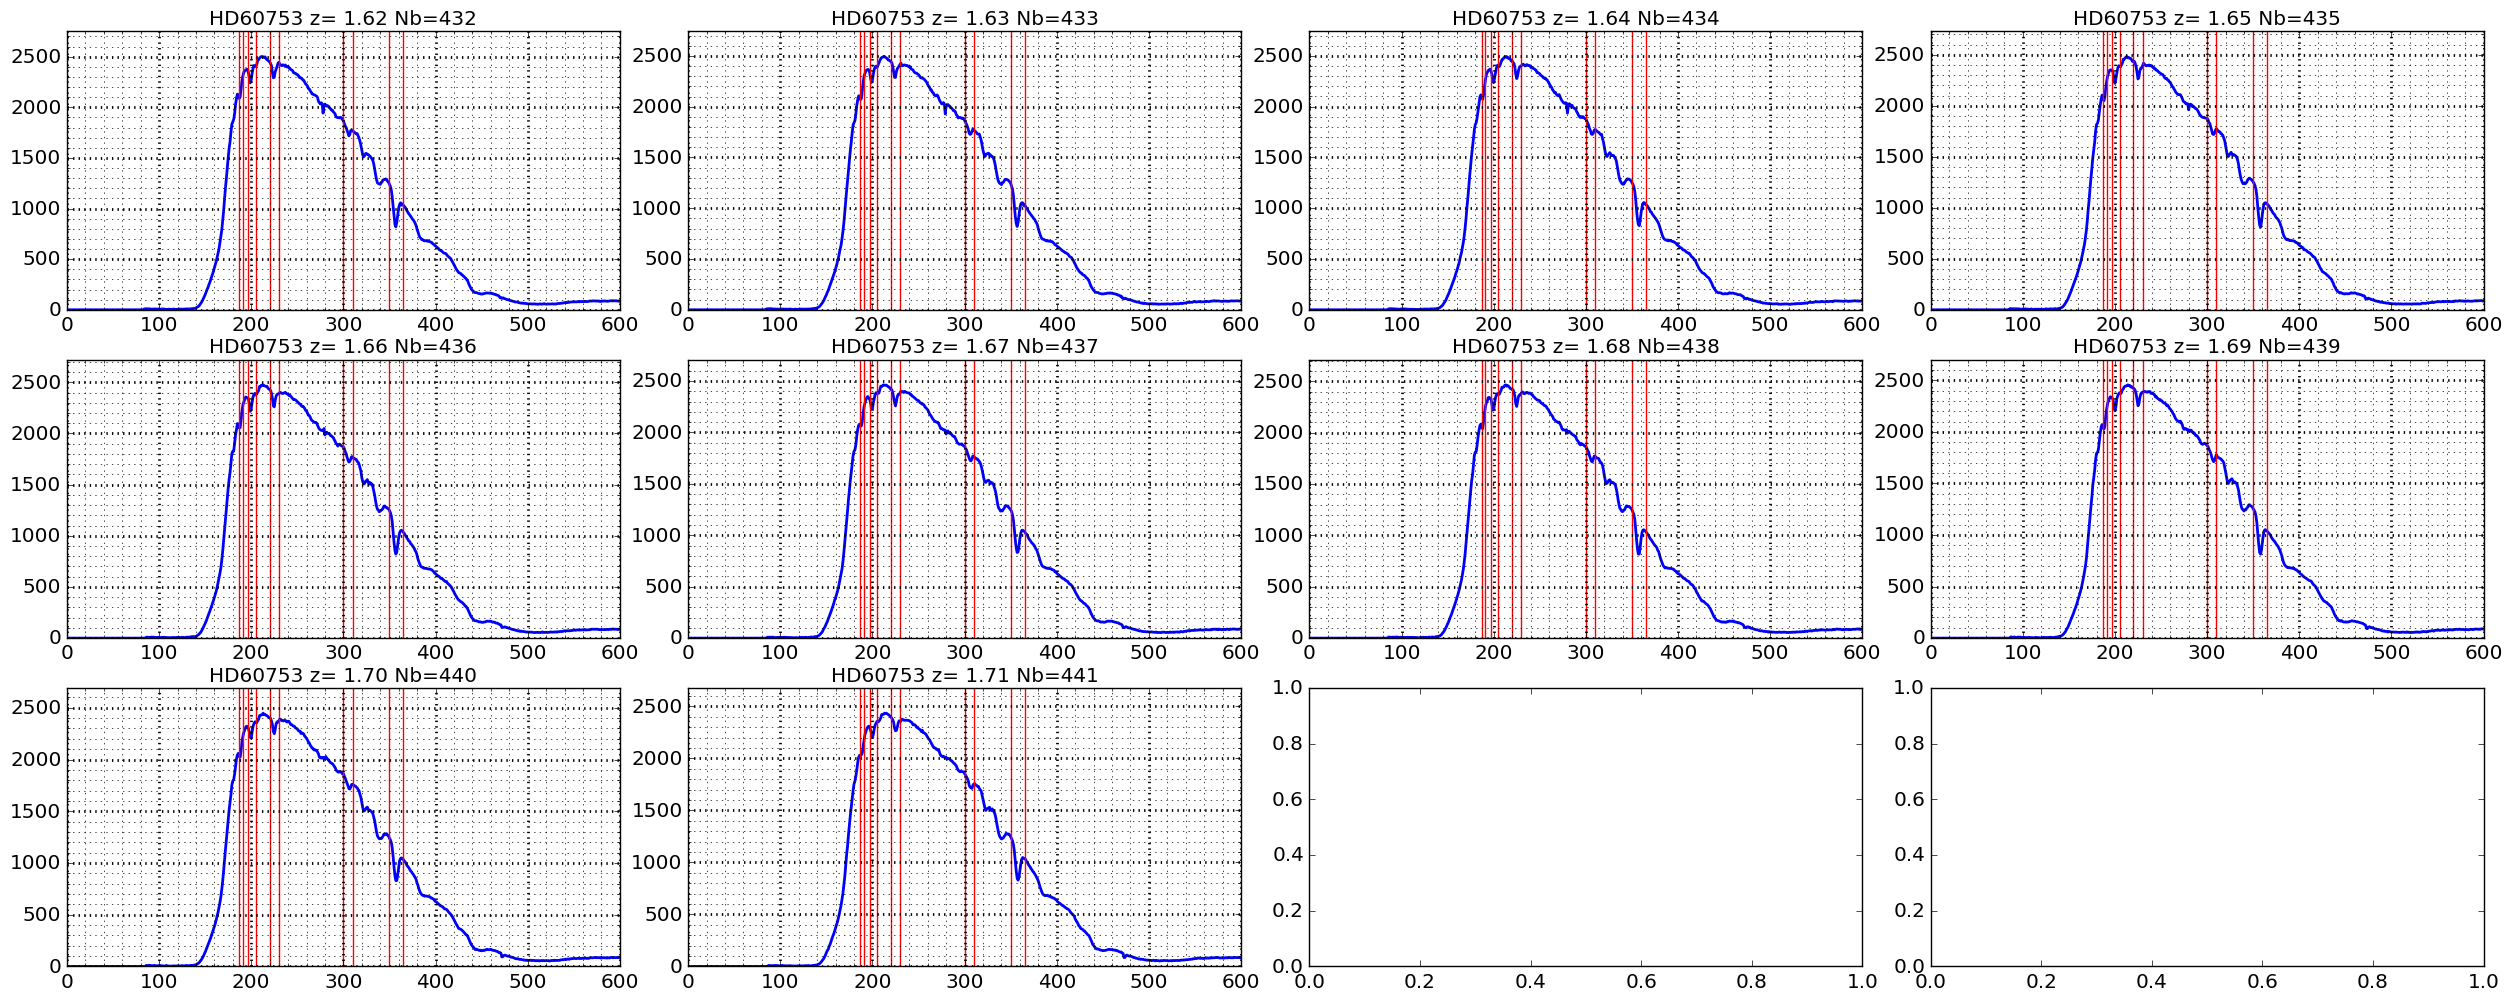

In [319]:
all_absorptionline_pix_right=FindAllAbsorptionLines(all_rightspectra,all_titles,object_name,'lineselectionregionsleft.pdf')

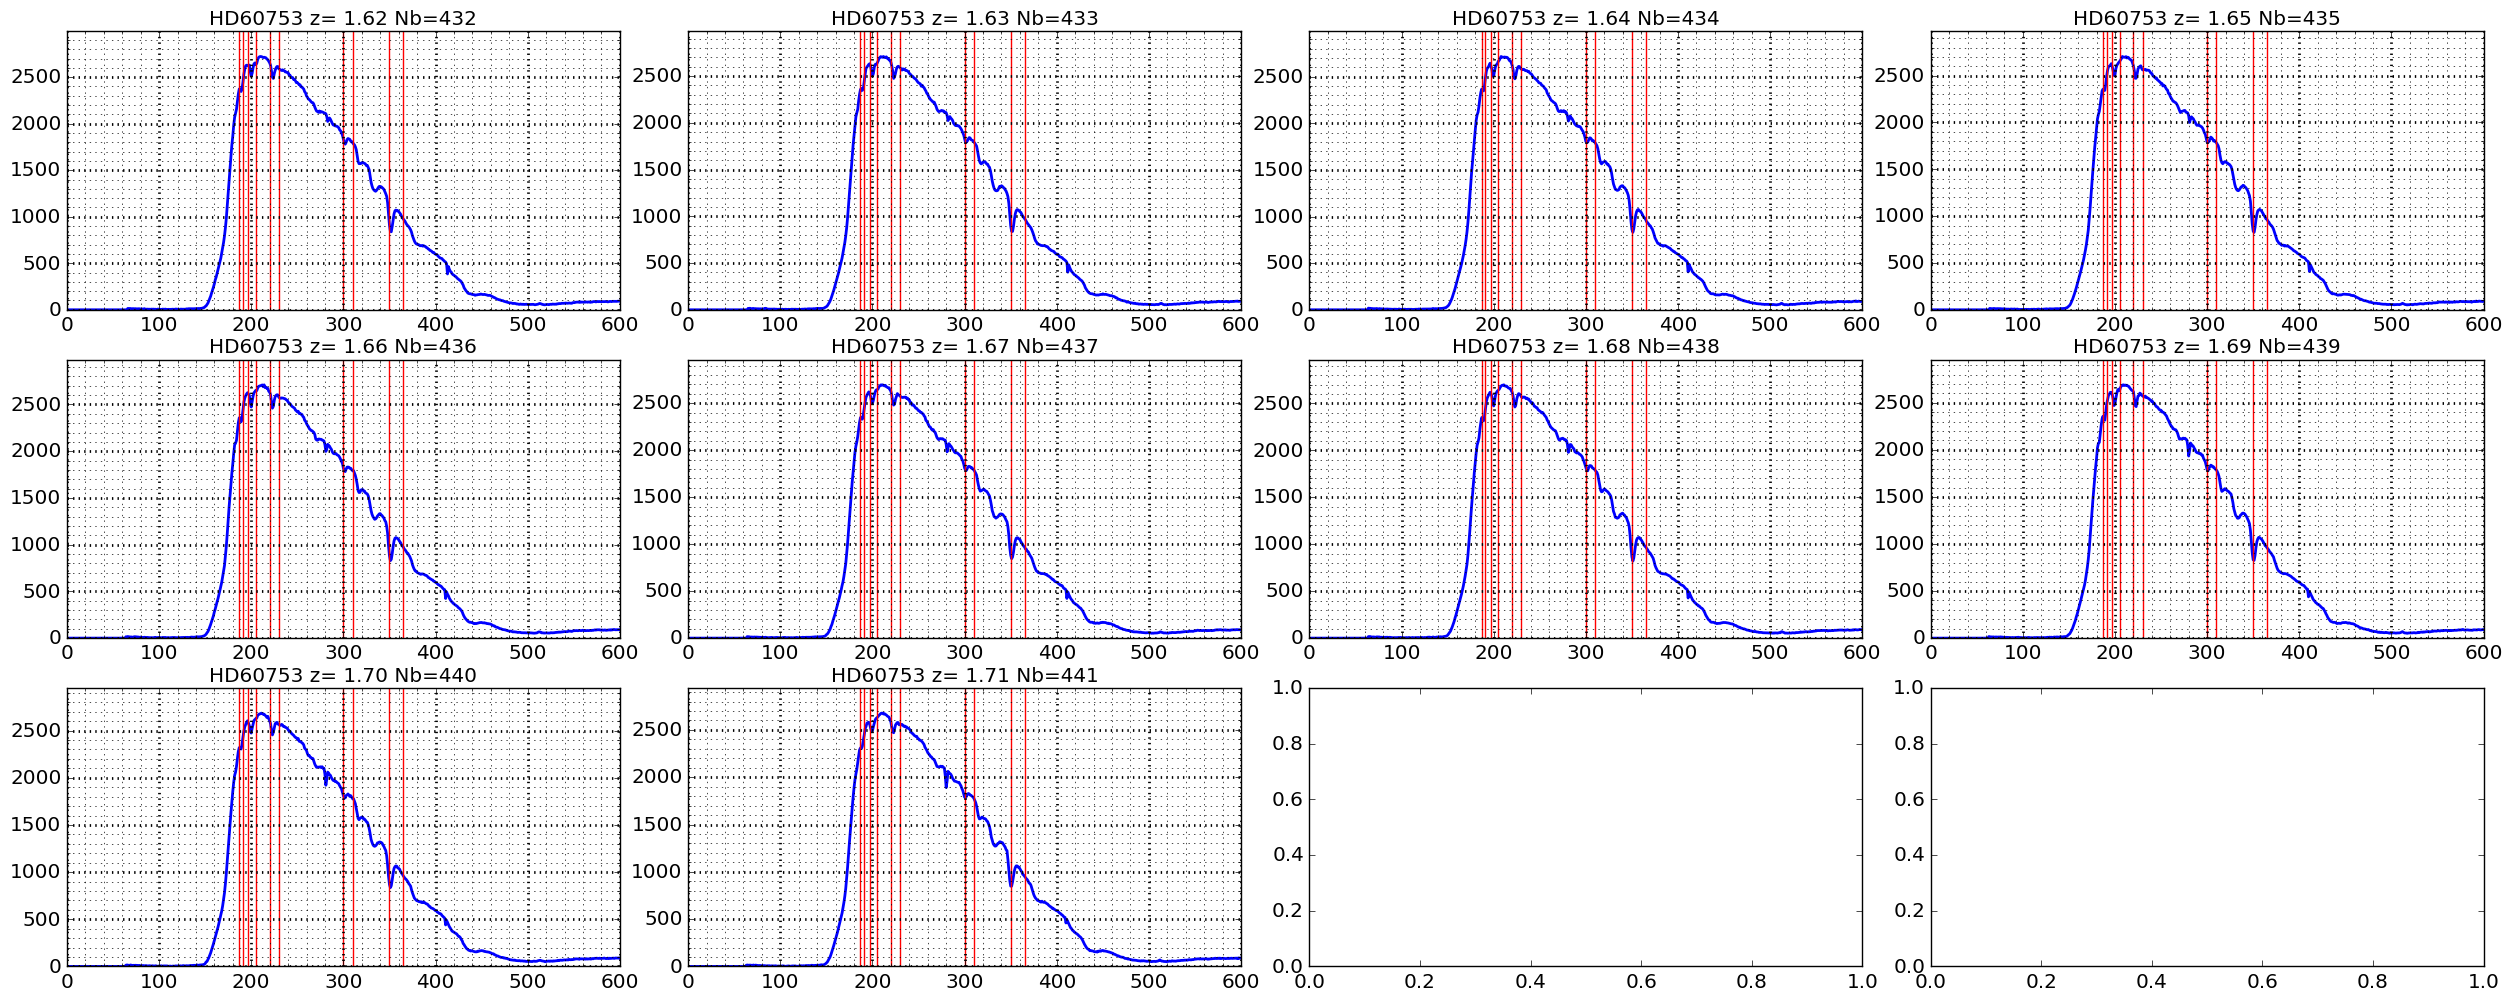

In [320]:
all_absorptionline_pix_left=FindAllAbsorptionLines(all_leftspectra,all_titles,object_name,'lineselectionregionsright.pdf')

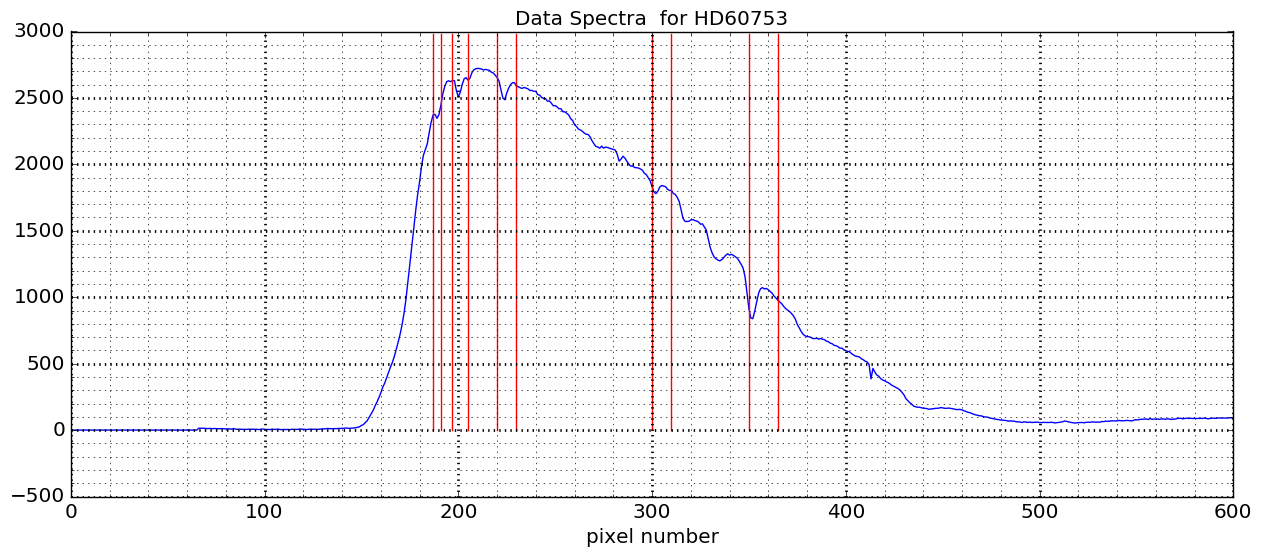

In [321]:
ymax=all_leftspectra[1].max()*1.1
ymin=0

fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.plot(all_leftspectra[0])
ax.set_xlim(0,600)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
# O2 boundary
ax.plot([pixminO2,pixminO2],[ymin,ymax],'r-')
ax.plot([pixmaxO2,pixmaxO2],[ymin,ymax],'r-')

ax.plot([pixminHa,pixminHa],[ymin,ymax],'r-')
ax.plot([pixmaxHa,pixmaxHa],[ymin,ymax],'r-')

ax.plot([pixminHb,pixminHb],[ymin,ymax],'r-')
ax.plot([pixmaxHb,pixmaxHb],[ymin,ymax],'r-')

ax.plot([pixminHg,pixminHg],[ymin,ymax],'r-')
ax.plot([pixmaxHg,pixmaxHg],[ymin,ymax],'r-')

ax.plot([pixminHd,pixminHd],[ymin,ymax],'r-')
ax.plot([pixmaxHd,pixmaxHd],[ymin,ymax],'r-')

title = 'Data Spectra  for {}'.format(object_name)
plt.title(title)
plt.xlabel('pixel number')

figfilename=os.path.join(dir_top_images,'lineselectionregions_left_sample.pdf')
plt.savefig(figfilename)

## Does the fit 1D with order FIT_ORDER
==================================================

In [322]:

#print all_absorptionline_pix_right

In [323]:
#%%cython
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def FitCalibrationCurve(all_absorptionline_pix ,wl_calib, all_titles,object_name,figname):
    """
    FitCalibrationCurve: Show the camibration curve
    ==============
    """
    NBABSLINES=5
    NBSPECTRA=all_absorptionline_pix.shape[0]
    MAXIMGROW=int(NBSPECTRA/4)+1
    
    #FIT_ORDER=2
    
    FitResults=np.zeros((NBSPECTRA,FIT_ORDER+1)) # for a polynom of order 1
    
    f, axarr = plt.subplots(MAXIMGROW,4,figsize=(25,10))
    f.tight_layout()

    for index in np.arange(0,NBSPECTRA):
        ix=index%4
        iy=index/4
        
        
        x=all_absorptionline_pix[index,:]
        y=wl_calib
        
        goodindexes = np.where(x!=0)
        
        x_new=x[goodindexes]
        y_new=y[goodindexes]
        
        z =  np.polyfit(x_new, y_new, FIT_ORDER)

        fitcurve = np.poly1d(z)
        x_fit=np.linspace(0,1000,100)
        y_fit=fitcurve(x_fit)
        
        FitResults[index,:]=z
        
        axarr[iy,ix].plot(x_new,y_new,'ro',lw=2)
        axarr[iy,ix].plot(x_fit,y_fit,'b-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        
        #axarr[iy,ix].set_xlim(0.,500.)
        #axarr[iy,ix].set_ylim(0.,1000.)
        axarr[iy,ix].grid(True)

        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
        
        figfilename=os.path.join(dir_top_images,figname)
        plt.savefig(figfilename)
        
    return FitResults
       

In [324]:
#%%cython
#import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib as mpl    
def FitCalibrationCurve2(all_absorptionline_pix ,wl_calib, all_titles,object_name,figname):
    """
    FitCalibrationCurve2: Show the camibration curve
    ==============
    """
    NBABSLINES=5
    NBSPECTRA=all_absorptionline_pix.shape[0]
    MAXIMGROW=int(NBSPECTRA/5)+1
    #FIT_ORDER=2
    
    FitResults=np.zeros((NBSPECTRA,FIT_ORDER+1)) # for a polynom of order 2
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))

    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
        
               
        x=all_absorptionline_pix[index,:]
        y=wl_calib
        
        goodindexes = np.where(x!=0)
        
        x_new=x[goodindexes]
        y_new=y[goodindexes]
        
        z =  np.polyfit(x_new, y_new, FIT_ORDER)
        print 'z = ',z
        fitcurve = np.poly1d(z)
        x_fit=np.linspace(0,1000,100)
        y_fit=fitcurve(x_fit)
        
        FitResults[index,:]=z

        ax.plot(x_new,y_new,'o',lw=2)
        ax.plot(x_fit,y_fit,'-',lw=2)
       
        
    #ax.set_xlim(0.,500.)
    #ax.set_ylim(0.,1000.)

    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    title='Fitted Calibration straight lines for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_xlabel("pixel number")
    ax.set_ylabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)
    
    return FitResults
       

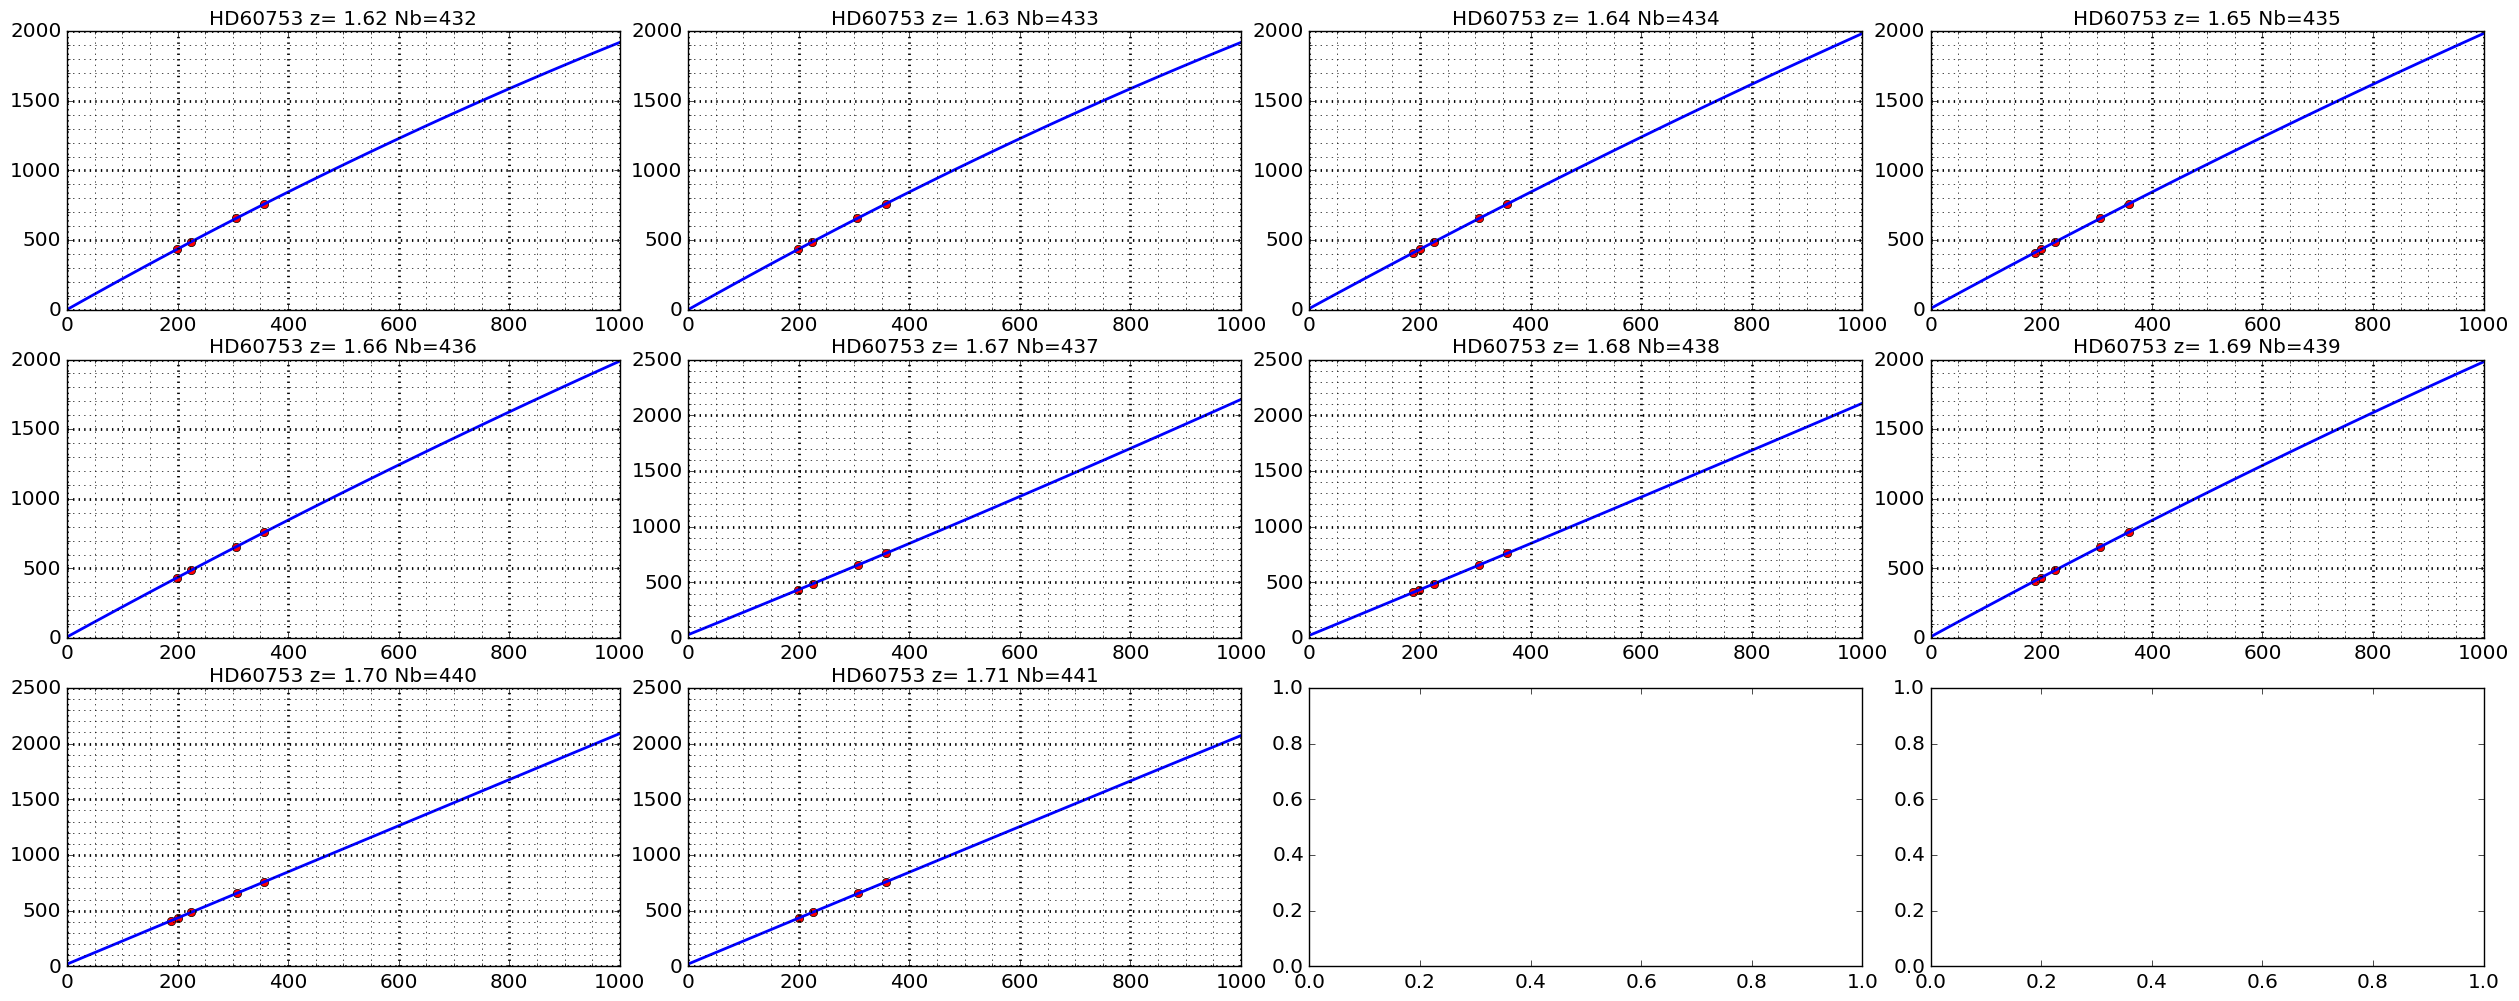

In [325]:
fit_res_right=FitCalibrationCurve(all_absorptionline_pix_right ,wl_calib, all_titles,object_name,'linefitsright.pdf')

z =  [ -3.20232792e-04   2.23877164e+00   1.01855217e+00]
z =  [ -3.20232792e-04   2.23877164e+00   1.01855217e+00]
z =  [ -1.89334298e-04   2.16297530e+00   9.53704606e+00]
z =  [ -1.89334298e-04   2.16297530e+00   9.53704606e+00]
z =  [ -1.94821859e-04   2.17538519e+00   7.95962276e+00]
z =  [  1.08624062e-04   2.00275016e+00   3.07393439e+01]
z =  [  3.86006537e-05   2.04356856e+00   2.50017488e+01]
z =  [ -1.89334298e-04   2.16297530e+00   9.53704606e+00]
z =  [ -7.27942973e-07   2.07024319e+00   2.05119044e+01]
z =  [ -1.51677132e-05   2.06531959e+00   2.18314306e+01]


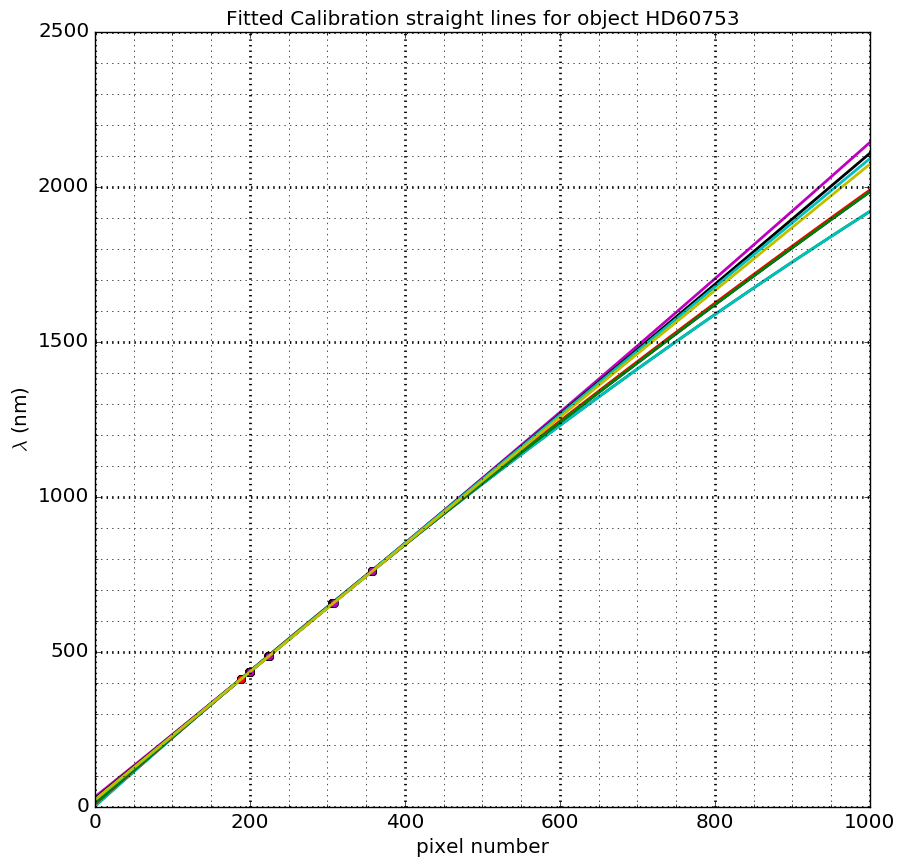

In [326]:
fit_res_right2=FitCalibrationCurve2(all_absorptionline_pix_right ,wl_calib, all_titles,object_name,'linefitsright2.pdf')

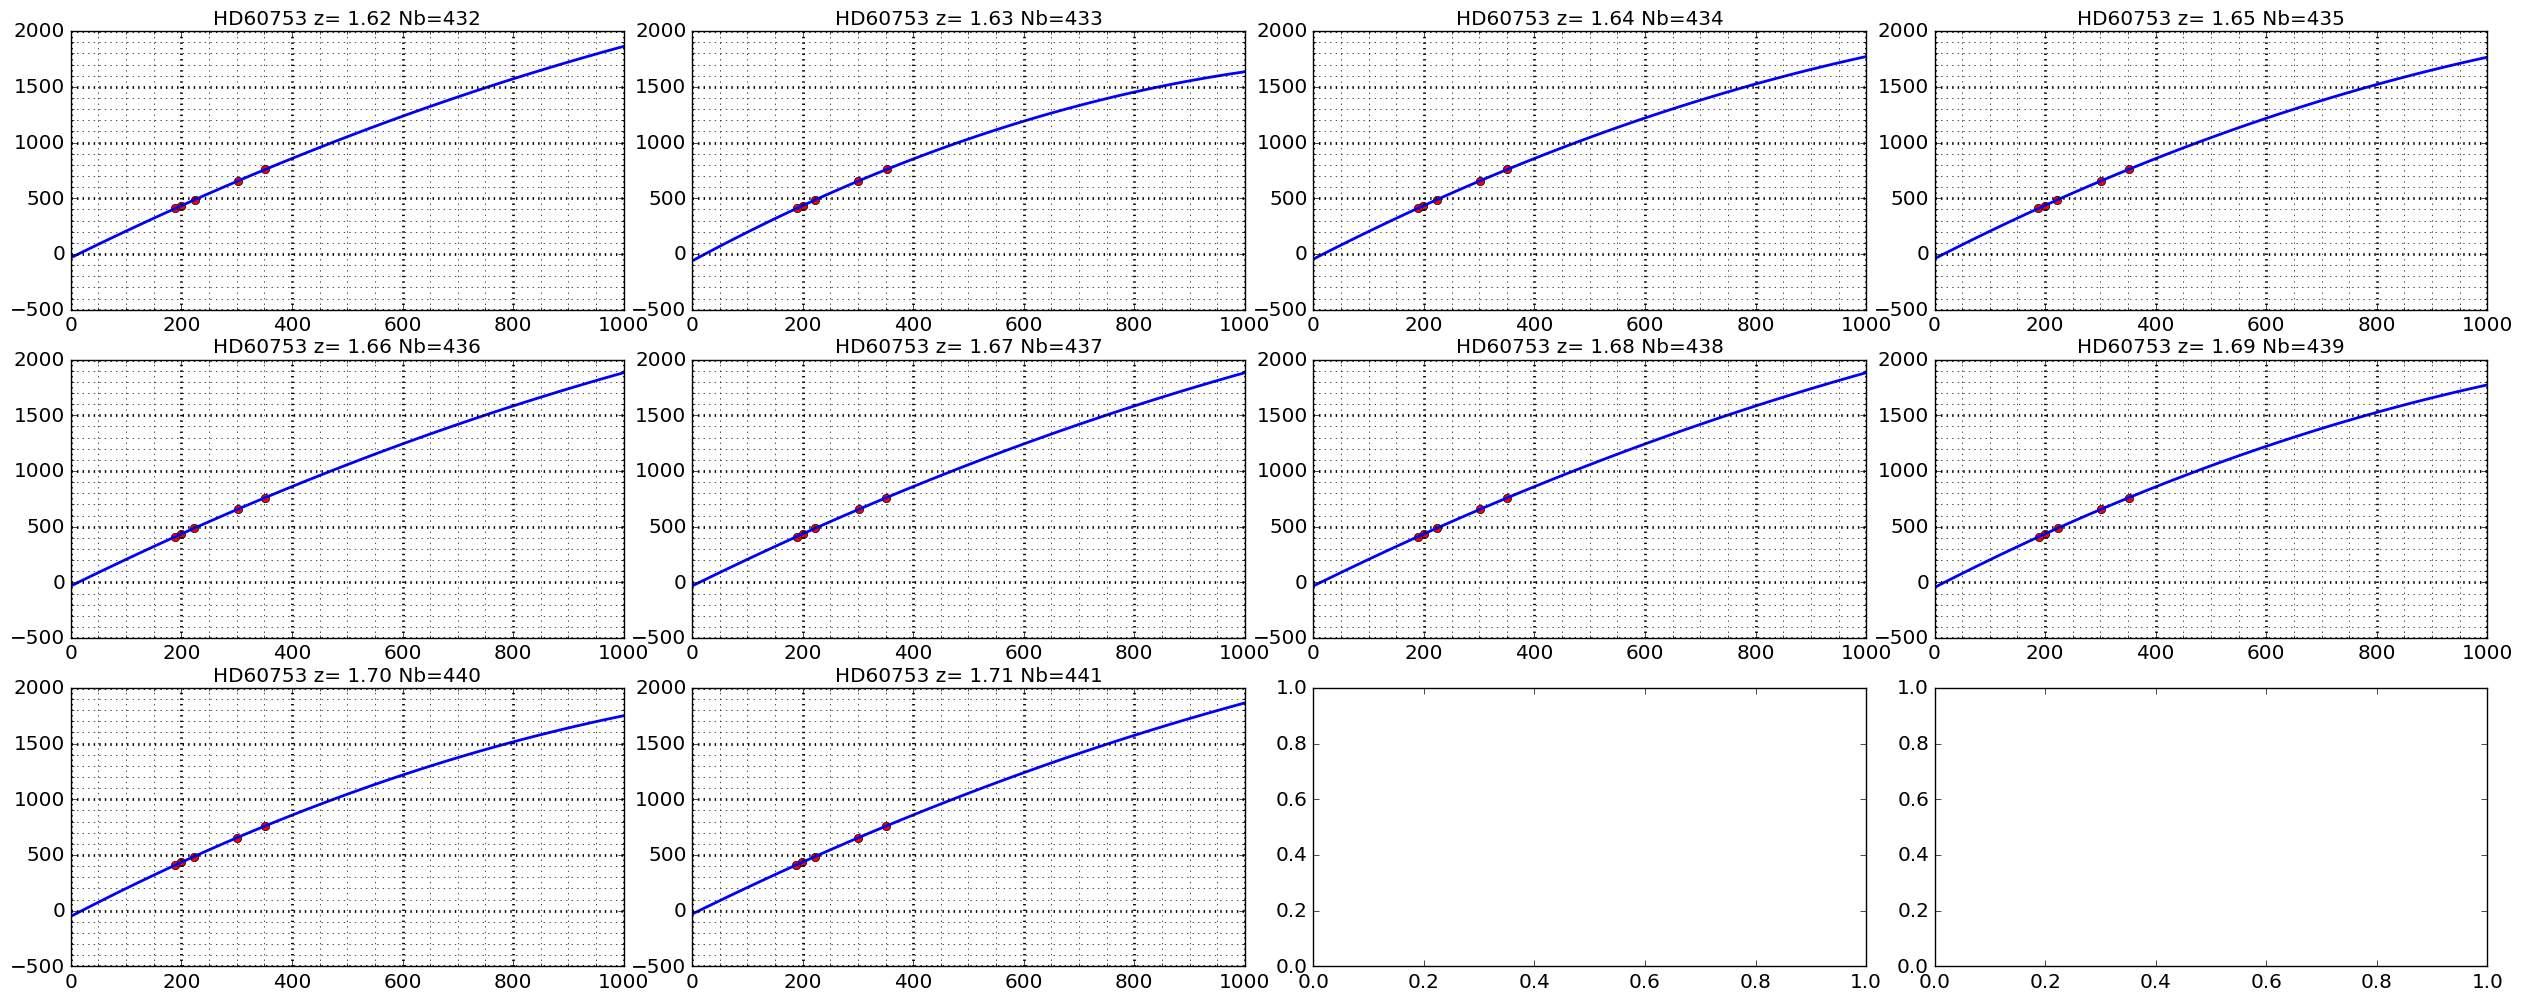

In [327]:
fit_res_left=FitCalibrationCurve(all_absorptionline_pix_left ,wl_calib, all_titles,object_name,'linefitsleft.pdf')

z =  [ -5.48864992e-04   2.44530785e+00  -3.30064681e+01]
z =  [ -9.82619616e-04   2.68058592e+00  -6.21775478e+01]
z =  [ -7.32636282e-04   2.55009431e+00  -4.53012220e+01]
z =  [ -7.29809524e-04   2.53798061e+00  -4.15376611e+01]
z =  [ -5.25742276e-04   2.43981203e+00  -3.23358151e+01]
z =  [ -5.25742276e-04   2.43981203e+00  -3.23358151e+01]
z =  [ -5.25742276e-04   2.43981203e+00  -3.23358151e+01]
z =  [ -7.32636282e-04   2.55009431e+00  -4.53012220e+01]
z =  [ -7.82722153e-04   2.58309985e+00  -5.06982313e+01]
z =  [ -5.48864992e-04   2.44421012e+00  -3.05617091e+01]


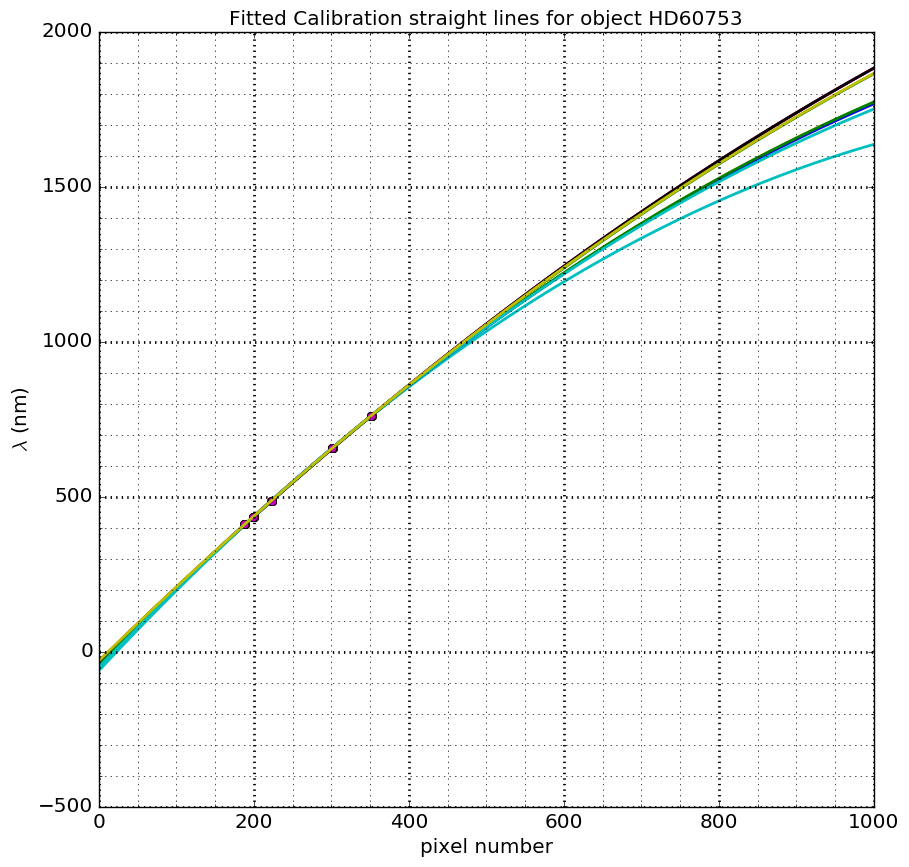

In [328]:
fit_res_left2=FitCalibrationCurve2(all_absorptionline_pix_left ,wl_calib, all_titles,object_name,'linefitsleft2.pdf')

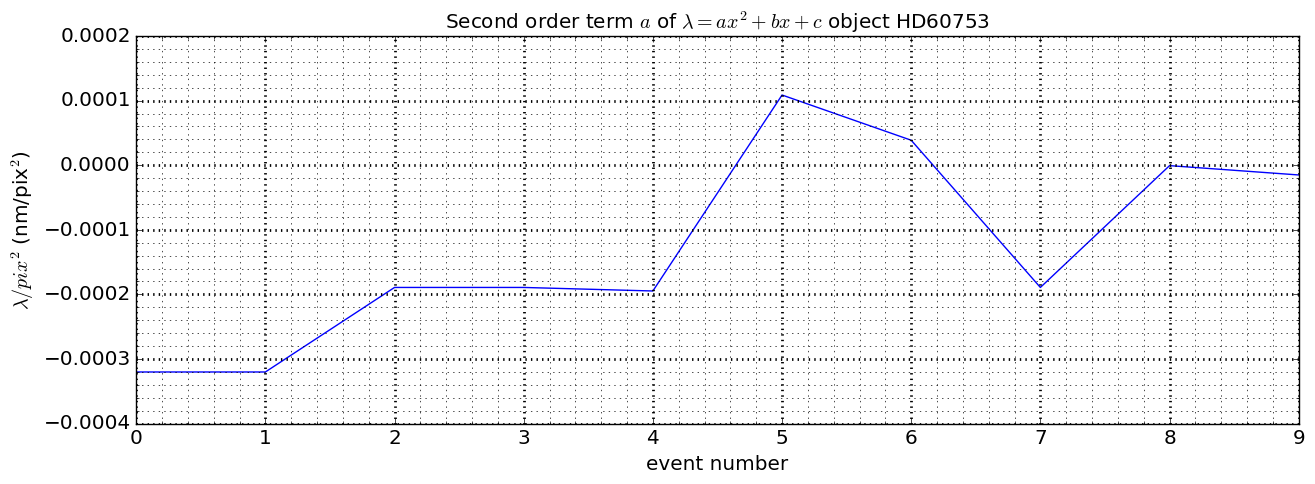

In [329]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(fit_res_right[:,0])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
title='Second order term $a$ of $\lambda = a x^2 + b x +c $ object {}'.format(object_name)
ax.set_title(title)
ax.set_xlabel("event number")
ax.set_ylabel("$\lambda/pix^2$ (nm/pix$^2$)")
figname='a_fit_term_rightspec.pdf'
figfilename=os.path.join(dir_top_images,figname)
plt.savefig(figfilename)

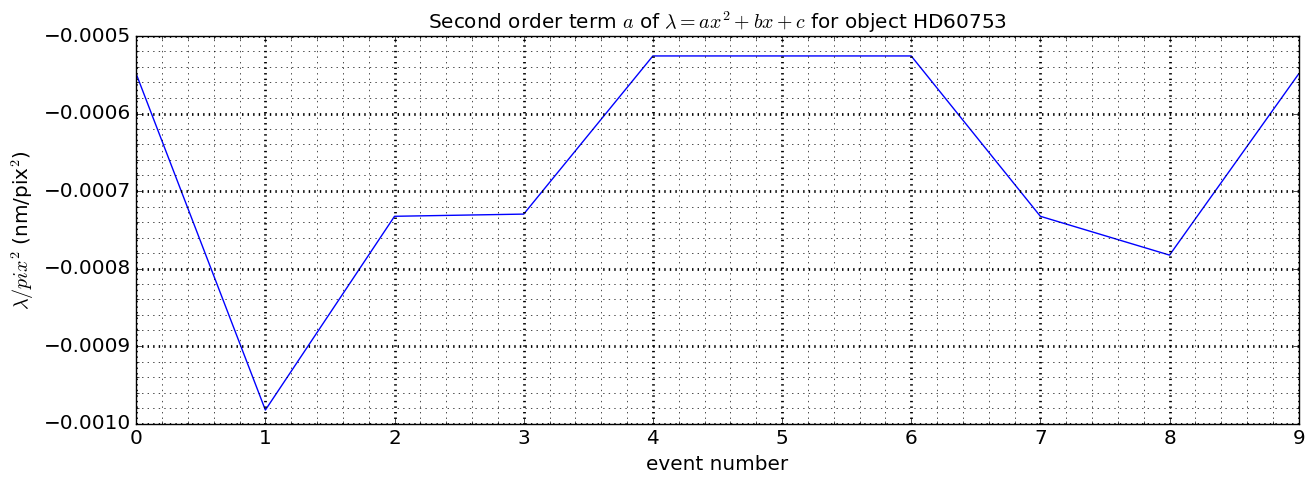

In [330]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(fit_res_left[:,0])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
title='Second order term $a$ of $\lambda = a x^2 + b x +c $ for object {}'.format(object_name)
ax.set_title(title)
ax.set_xlabel("event number")
ax.set_ylabel("$\lambda/pix^2$ (nm/pix$^2$)")
#ax.set_ylim(2.0,2.2)
figname='a_fit_term_leftspec.pdf'
figfilename=os.path.join(dir_top_images,figname)
plt.savefig(figfilename)

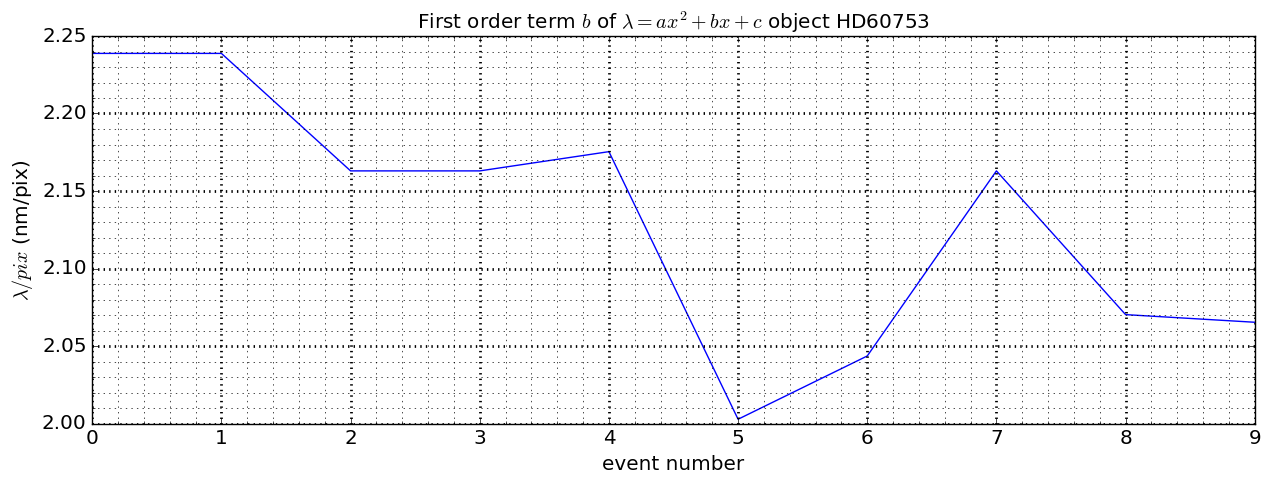

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(fit_res_right[:,1])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
title='First order term $b$ of $\lambda = a x^2 + b x +c $ object {}'.format(object_name)
ax.set_title(title)
ax.set_xlabel("event number")
ax.set_ylabel("$\lambda/pix$ (nm/pix)")
#ax.set_ylim(0,35)
figname='b_fit_term_rightspec.pdf'
figfilename=os.path.join(dir_top_images,figname)
plt.savefig(figfilename)

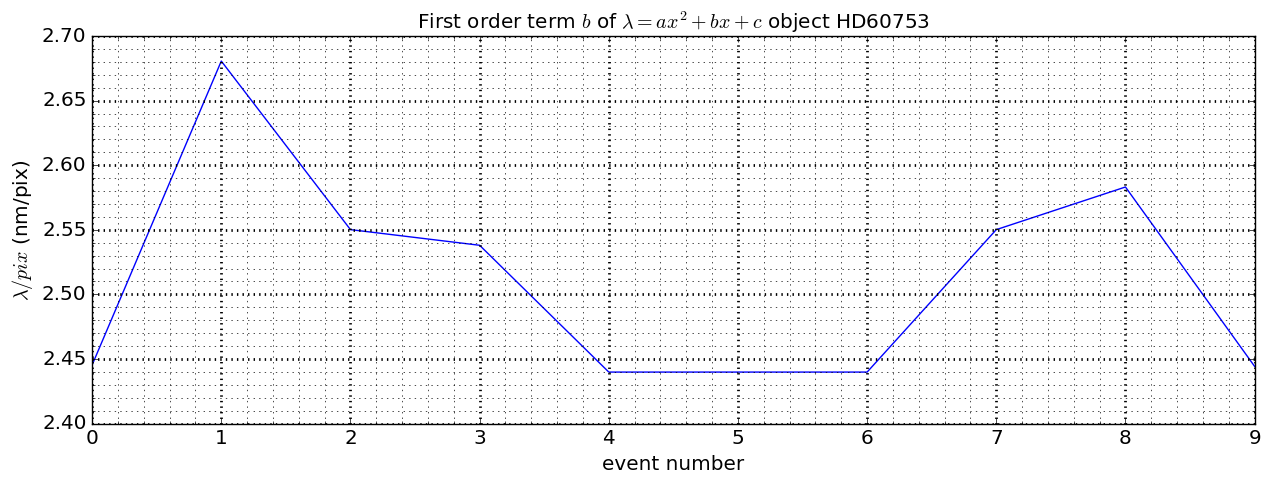

In [332]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(fit_res_left[:,1])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
title='First order term $b$ of $\lambda = a x^2 + b x +c $ object {}'.format(object_name)
ax.set_title(title)
ax.set_xlabel("event number")
ax.set_ylabel("$\lambda/pix $ (nm/pix)")
#ax.set_ylim(0,35)
figname='b_fit_term_leftspec.pdf'
figfilename=os.path.join(dir_top_images,figname)
plt.savefig(figfilename)

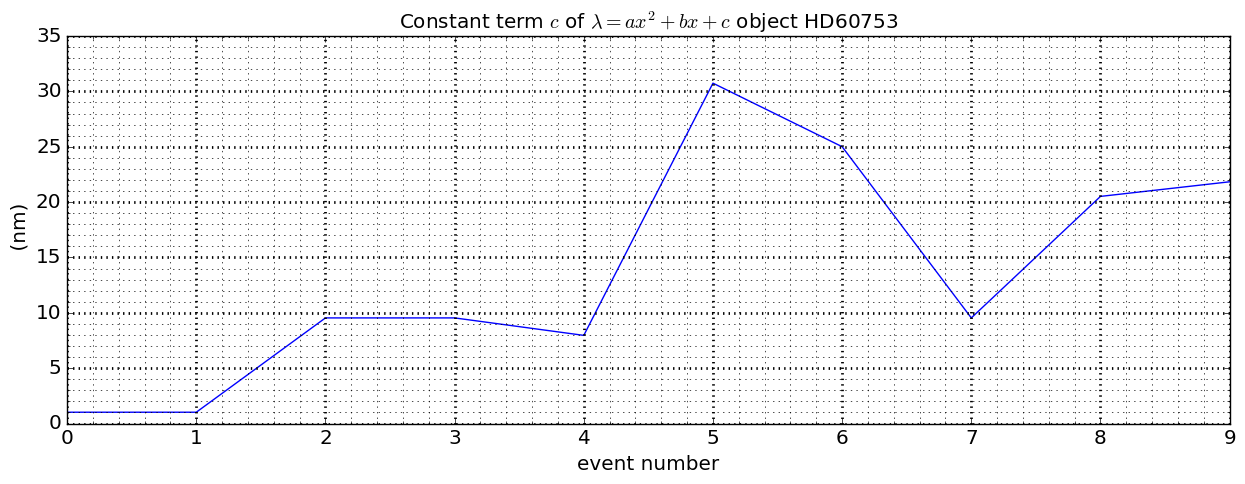

In [333]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(fit_res_right[:,2])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
title='Constant term $c$ of $\lambda = a x^2 + b x +c $ object {}'.format(object_name)
ax.set_title(title)
ax.set_xlabel("event number")
ax.set_ylabel(" (nm)")
#ax.set_ylim(0,35)
figname='c_fit_term_rightspec.pdf'
figfilename=os.path.join(dir_top_images,figname)
plt.savefig(figfilename)

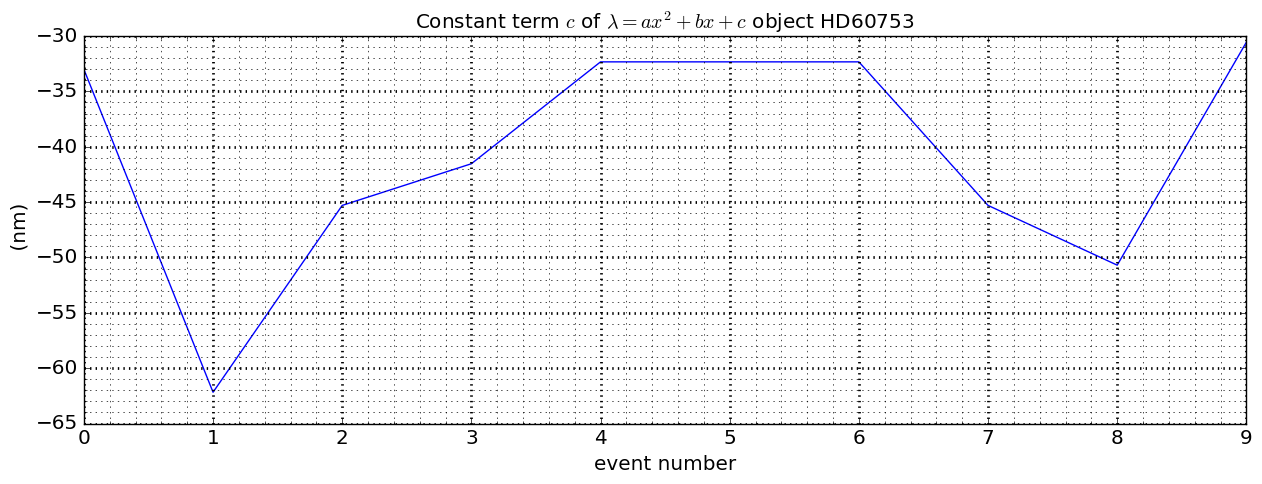

In [334]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(fit_res_left[:,2])
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
title='Constant term $c$ of $\lambda = a x^2 + b x +c $ object {}'.format(object_name)
ax.set_title(title)
ax.set_xlabel("event number")
ax.set_ylabel(" (nm)")
#ax.set_ylim(0,35)
figname='c_fit_term_leftspec.pdf'
figfilename=os.path.join(dir_top_images,figname)
plt.savefig(figfilename)

### Save outputfilename
Results of the fits for right and left spectra are saved as images

In [335]:
prihdr = fits.Header()
prihdr['ANALYST'] = 'Sylvie Dagoret-Campagne'
prihdr['COMMENT'] = "Fits straight line on spectra"
prihdr['OBJ-NAME'] = object_name
prihdu = fits.PrimaryHDU(header=prihdr)
hdulist = fits.HDUList([prihdu])

In [336]:
hdu1=fits.ImageHDU(data=fit_res_right)  # save fits results for right spectra
hdu2=fits.ImageHDU(data=fit_res_left)   # save fits results for left spectra

In [337]:
hdulist.append(hdu1)
hdulist.append(hdu2)

In [338]:
hdulist.writeto(simspectracalibresult,clobber=True)

In [339]:
print hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   ()      
  1              ImageHDU         7   (3, 10)   float64   
  2              ImageHDU         7   (3, 10)   float64   
None


In [340]:
hdulist.close()